The following script consists of a Python version of Andrew Ng Stanford Course 'Machine Learning' taught on the Coursera Platform
Note: All exercise data and structure are credited to Stanford University 

**Caveat:** Contrary to the modularity presented in Octave scripts and as I'm using Jupyter Notebooks for educational purposes we will implement the functions on the same notebook where we will call them

# Exercise 1 - Regularized Linear Regression

In [215]:
#Import numpy libraries to deal with matrixes and vectors
import numpy as np
#Import pandas do read data files
import pandas as pd
#Import matplotlib to plot data
import matplotlib.pyplot as plt

#Import math 
import math 

#Import scipy optimization function
from scipy import optimize, io
from scipy.ndimage import rotate

#Import linalg norm
from numpy.linalg import norm

#Matplotlib notebook property
%matplotlib inline

In [503]:
#Use scipy Io to load matrix object
ex5_file = io.loadmat('ex5data1.mat')
X = np.array(ex5_file['X'])
y = np.array(ex5_file['y'])

#Assign test set
X_test = np.array(ex5_file['Xtest'])
y_test = np.array(ex5_file['ytest'])

#Assign validation set
X_val = np.array(ex5_file['Xval'])
y_val = np.array(ex5_file['yval'])

print('# of training examples: {}'.format(len(X)))
m = len(X)

# of training examples: 12


The table consists of raw data collected from a dam and the objective of the model is to predict the water flowing out of it using the change of water level in the reservoir. In this script we will also explore the concept of bias vs. variance

In [217]:
def plotData(X: np.array,y: np.array):
    plt.scatter(X, y, marker='X', color='red')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')

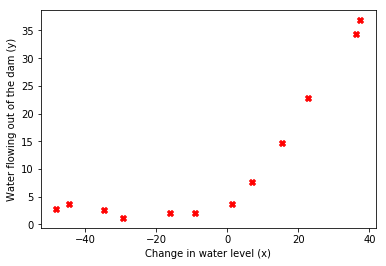

In [218]:
#Plot our data showing Change in Water level in y-axis and Water flowing out of the dam in the x-axis
plotData(X,y)

Let's fit a regularized linear regression and check the value of the cost function and the value of it's gradient.
<br>
Recall that the cost function formula for the regularized linear regression is:

<img src="assets/CostFunction.JPG">

And the gradient formula is:

<img src="assets/GradientRegularizedLinearRegression.JPG">

<b>Recall that higher lambda values increase the penalization on model parameters, therefore, reducing overfitting.

In [326]:
#Define cost function and gradient function

def linearRegCostFunction(theta: np.array, X: np.array, y: np.array,lambdas: int):
   
    #Reshape Theta
    theta = theta.reshape(theta.shape[0],1)
    
    #Add Bias term to X
    ones_vector = np.ones((len(X),1))
    X_extended = np.hstack((ones_vector,X)) 
    
    #Calculate number of examples in sample
    m = len(y)
    #Calculate hypothesis
    h = np.dot(theta.T.reshape(1,theta.shape[0]), X_extended.T)
    
    #Calculate error
    error = h.T - y

    J = sum(error**2)/(2*m) + lambdas/(2*m)*sum(theta[1:]**2)
    #Calculate gradient, avoid regularization of Theta 0
    grad = np.dot(error.T,X_extended) / m + np.append(np.array(0), (lambdas/m*theta[1:]))
    
    return J, grad

In [327]:
theta = np.array([1,1])
#Reshape the original array
theta = theta.reshape(len(theta),1)

#Check cost function and theta from regularized linear regression
J, grad = linearRegCostFunction(theta,X,y, 1)

In [328]:
print('Cost at theta [1,1] is {}'.format(float(J)))

Cost at theta [1,1] is 303.9931922202643


In [329]:
print('Grad at theta [1,1] is {}, {}'.format(float(grad[:,0]), float(grad[:,1])))

Grad at theta [1,1] is -15.303015674201186, 598.2507441727037


In [541]:
#Train Linear Regression 

# implementation based on Gerges Dib (github user:dibgerge) - optimizing our costFunction using scipy optimize library. 
# We minimize the cost function starting on the initial theta 
# TNC means Truncated Newton Algorithm and maxiter is set to 50 
def trainLinearRegression(linearRegCostFunction, X, y, lambda_):
    #Expect N values for theta + 1 (bias term theta)
    initial_theta = np.zeros((X.shape[1]+1,1))

    options= {'maxiter': 200}

    res = optimize.minimize(linearRegCostFunction,
                            initial_theta,
                            (X,y,lambda_),
                            jac=True,
                            method='TNC',
                            options=options)
    
    return res.x

In [542]:
print('Optimal theta found by optimize method: {}'.format((trainLinearRegression(linearRegCostFunction, X, y, 0))))

opt_theta = trainLinearRegression(linearRegCostFunction, X, y, 0)

Optimal theta found by optimize method: [13.08790351  0.36777923]


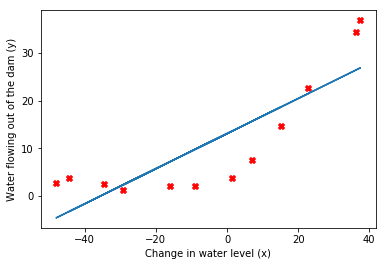

In [543]:
#Create X extended version with Bias term - we will use it to plot our best-fitted line
ones_vector = np.ones((len(X),1))
X_extended = np.hstack((ones_vector,X))
    
#Plot our data showing Change in Water level in y-axis and Water flowing out of the dam in the x-axis 
#Plot the corresponding line resulting from the regularized linear regression
plotData(X,y)
plt.plot(X_extended[:,1],np.dot(opt_theta.T,X_extended.T))

Notice how our points do not follow a linear trend. Our line resulting from minimizing the cost function can't capture the effects of this data. In 2-D it is easy to understand this but most of the cases you need to resort to other techniques to understand this.

Our model shows an classical example of a high biased one. The opposite (a high variance one) would be a model with the line perfectly fitting our data points, thus being overfitted.

Let's plot the learning curves for the fitted scenario:

# Exercise 2 - Plotting Learning Curves

In [548]:
#Define new lambda 

lambda_ = 0

#Define Learning Curve function
def learningCurve(linearRegCostFunction, X: np.array, y: np.array, X_val: np.array, y_val: np.array, lambda_: int) -> (np.array, np.array):

        #Number of training examples 
        
        m = len(X)
        
        #Create empty arrays for each error calculation
        error_train = np.zeros((m,1))
        error_val = np.zeros((m,1))
        
        #Train linear regression with an ascending number of samples
        
        for i in range(0,m):
            #Obtain subset of training examples
            batch_features = X[0:i+1, :]
            batch_target = y[0:i+1,:]
            
            #Obtain optimal theta for given examples and obtain the cost function given that theta
            theta_train = trainLinearRegression(linearRegCostFunction, batch_features, batch_target, lambda_)
            iter_j_train = linearRegCostFunction(theta_train, batch_features, batch_target, lambda_)
            
            #Fit optimal model on Validation set (unseen data)
            iter_j_val = linearRegCostFunction(theta_train, X_val, y_val, lambda_)
            #Assign training error to corresponding array position
            error_train[i] = iter_j_train[0]
            error_val[i] = iter_j_val[0]
        
        return error_train, error_val


In [549]:
#Obtain Learning  Curves
error_train, error_val = learningCurve(linearRegCostFunction, X, y, X_val, y_val, 0)

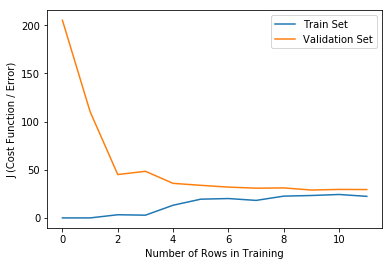

In [550]:
#Plot Cost function on train and validation sets 
plt.plot(error_train)
plt.plot(error_val)
plt.xlabel('Number of Rows in Training')
plt.ylabel('J (Cost Function / Error)')
plt.legend(['Train Set','Validation Set'])

Notice how the error keeps increasing on the training set, being high for both validation and train sets when we are increasing the number of rows.
The plot shows a classical learning curve for a high bias model. As we have seen, our fitted line does not capture the effects of the water flowing out of the dam given the change in water level.

For this scenario, probably the features that we are using will not be sufficient to develop a good model, no matter the sample size we can gather.

**What can we do to improve the model?**

# Exercise 3 - Polynomial Regression

In [551]:
#Define polynomial order

p = 8 

def polyFeatures(X: np.array, p:int)-> np.array: 
    #Add column of ones to the array 
    X_poly = np.zeros((X.shape[0], p))
    for i in range(1,p+1):
        #Raise X to the power of i 
        X_poly[:,i-1] = (X ** i).reshape(len(X))

    return X_poly

In [552]:
X_poly = polyFeatures(X,8)

In [553]:
def featureNormalize(X: np.array, mu=[], sigma = 0) -> np.array:
    '''
    Normalizes features by subtracting the mean and dividing the value by a standard deviation    
    '''
    #If mu not stated in function, compute
    if len(mu) == 0:
        mu = np.mean(X, axis=0)
        #One degree of freedom in standard deviation to match Octave implementation
        sigma = np.std(X, axis=0, ddof=1)
        
    X_standardized = (X - mu)/sigma
    return X_standardized, mu, sigma

In [554]:
X_poly, mu, sigma = featureNormalize(X_poly)

In [555]:
#Map X_test and X_Val using Mu and Sigma from training set

X_poly_test = polyFeatures(X_test,p)
X_poly_test, _, _ = featureNormalize(X_poly_test, mu, sigma)

In [556]:
#Map X_test and X_Val using Mu and Sigma from training set

X_poly_val = polyFeatures(X_val,p)
X_poly_val, _ ,_ = featureNormalize(X_poly_val, mu, sigma)

#Add Bias term to X Validation Set
ones_vector = np.ones((len(X_poly_val),1))
X_poly_val_extended = np.hstack((ones_vector,X_poly_val)) 

Now that we have our polynomial features, we are going to train our polynomial regression using them. Naturally, the line will not be a completely linear one but instead will have some curves associated with them. We will set lambda = 0 to match Octave implementation.

**Polynomial regression formula is as follows:**

<img src="assets/PolynomialRegression.JPG">

In [573]:
opt_theta_poly = trainLinearRegression(linearRegCostFunction, X_poly, y, 100)

print('Optimal theta found by optimize method: {}'.format((opt_theta_poly)))

Optimal theta found by optimize method: [11.21758935  0.96420878  0.32296631  0.74742798  0.14423032  0.5558083
  0.02028321  0.41869296 -0.05800437]


In [574]:
def plotPolynomial(optimal_theta,mu,sigma,n, p, X, y):
    '''
    Plots polynomial regression for n sample points
    We plot the original data and a regression line using the optimal_theta parameter
    '''
    
    x_axis = np.linspace(min(X)-15,max(X)+25,2512)

    xmat = polyFeatures(x_axis,p)
    
    #This is undoing feature normalization
    
    xmat, _, _ = featureNormalize(xmat, mu, sigma)
    
    #Add Bias Term
    ones_vector = np.ones((len(xmat),1))
    xmat = np.hstack((ones_vector,xmat))     
    #print(xmat)
    plotData(X,y)
    
    h = np.dot(xmat,optimal_theta.reshape(optimal_theta.shape[0],1))
    plt.plot(x_axis,h,'b--')
    
    plt.legend(['Polynomial Regression Fitted Line', 'Real Data Points'])

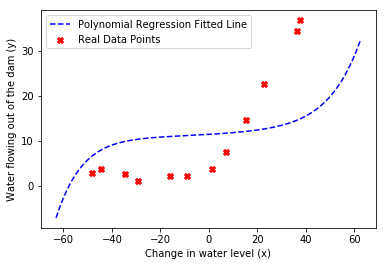

In [575]:
plotPolynomial(opt_theta_poly,mu,sigma,100, 8, X, y)

# Exercise 4 - Bias vs. Variance Tradeoff

In [576]:
#Obtain Learning  Curves for Polynomial Regression
error_train_poly, error_val_poly = learningCurve(linearRegCostFunction, X_poly, y, X_poly_val, y_val, 100)

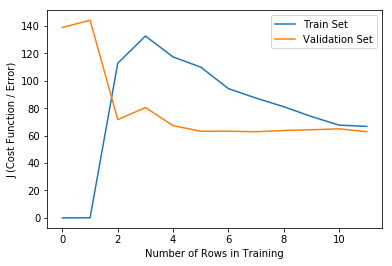

In [577]:
#Plot Cost function on train and validation sets using polynomial regression with lambda set to 0
plt.plot(error_train_poly)
plt.plot(error_val_poly)
plt.xlabel('Number of Rows in Training')
plt.ylabel('J (Cost Function / Error)')
plt.legend(['Train Set','Validation Set'])

Notice how the learning curve is completely different in the polynomial regression we have trained above. Training set cost function is higher in most iteration as you are now clearly capture the effects of the target variable. What happens when we set regularization to zero?

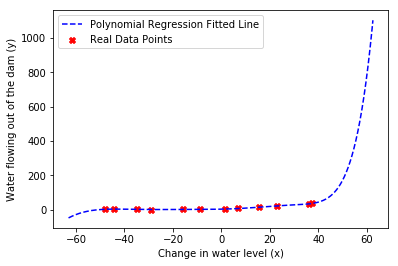

In [578]:
opt_theta_poly_lambda_0 = trainLinearRegression(linearRegCostFunction, X_poly, y, 0)
plotPolynomial(opt_theta_poly_lambda_0,mu,sigma,100, 8, X, y)

The fitted line is perfectly adapting itself to the points on the curve. The problem is, when you have new data points your fitted line may not generalize well enough, hence the necessity of regularization.

In [579]:
#Obtain Learning  Curves for Polynomial Regression
error_train_poly_lambda_0, error_val_poly_lambda_0 = learningCurve(linearRegCostFunction, X_poly, y, X_poly_val, y_val, 1)

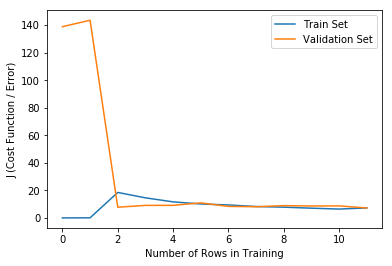

In [580]:
#Plot Cost function on train and validation sets using polynomial regression
plt.plot(error_train_poly_lambda_0)
plt.plot(error_val_poly_lambda_0)
plt.xlabel('Number of Rows in Training')
plt.ylabel('J (Cost Function / Error)')
plt.legend(['Train Set','Validation Set'])

How can we select lambda?

In [611]:
def validationCurve(linearRegCostFunction, X: np.array, y: np.array, X_val: np.array, y_val: np.array):
    lambda_vec = np.array([0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10])
    m = len(lambda_vec)
    
    #Create empty arrays for each error calculation per lambda
    error_train = np.zeros((m,1))
    error_val = np.zeros((m,1))
    
    for i in range(0,m):
        opt_theta = trainLinearRegression(linearRegCostFunction, X, y, lambda_vec[i])
        j_train = linearRegCostFunction(opt_theta, X, y, lambda_vec[i])[0]
        
        error_train[i] = j_train
        
        #Fit Obtain Test Set Cost Function
        j_val = linearRegCostFunction(opt_theta, X_val, y_val, lambda_vec[i])[0]
        
        error_val[i] = j_val
        
    return error_train, error_val

In [612]:
error_train_lambda, error_val_lambda = validationCurve(linearRegCostFunction, X_poly, y, X_poly_val, y_val)

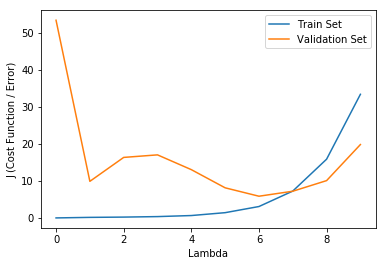

In [613]:
#Plot Cost function on train and validation sets using polynomial regression
plt.plot(error_train_lambda)
plt.plot(error_val_lambda)
plt.xlabel('Lambda')
plt.ylabel('J (Cost Function / Error)')
plt.legend(['Train Set','Validation Set'])

Iterating through lambdas help us visualize the effect of regularization in the cost function and choose the appropriate lambda. In the above example a lambda of 7 is where both lines cross. If you want to allow some overfitting in the model you can choose lambda = 6 as it minimizes the validation error. **Checking the fitted line with lambda = 6:**

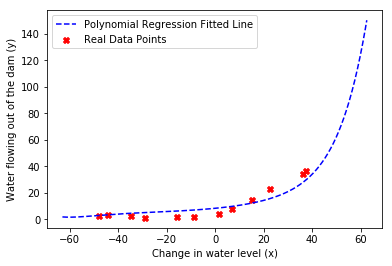

In [615]:
opt_theta_lambda_6 = trainLinearRegression(linearRegCostFunction, X_poly, y, 6)
plotPolynomial(opt_theta_lambda_6,mu,sigma,100, 8, X, y)